# Identifying users likely to spend after completing game tutorial.

## Introduction

Kabam offers freemium games -- their games are free to play, but users have the choice of getting additional features
by spending money on them.
A game designer would like to understand which users are likely to spend money in a game after completing the tutorial,
so that different prices can be offered to users who are likely to spend.
For example, if the model predicts that a user is more likely to spend money on the games, the prices of in-game add-ons
can be increased, therefore increasing revenue for Kabam.

Posed as a data science question, the problem can be phrased as:
- Can we create a binary classification model that predicts whether users are likely to spend based on information available during the tutorial?
- If so, according to the model, what is the profile of a user that is likely to spend, as opposed to a user who isn't?

We use a gradient boosted trees model for spend prediction.

Given that the dataset poses massive class imbalance (as we'll see later), we'll judge the quality of the model based on two factors:
- Given that the user won't spend money, can the model predict this accurately?
- Given that the user will spend money, can the model predict this accurately as well?

# Data Processing and Exploratory Analysis

## Prepare libraries and settings

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import xgboost as xgb
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_X_y
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

We have three types of data:
- demographic information regarding the user (in `ka_users.csv`),
- actions taken by the user in the game (in `ka_actions.parquet`), and
- information regarding the device used by the user (in `ka_device.db`).

We'll join them together into one dataframe.

In [2]:
# Data paths
users_path = "data/ka_users.csv"
actions_path = "data/ka_actions.parquet"
devices_path = "data/ka_devices.db"

# File name of merged data
merged_data_path = "data/processed/kabam.csv"

# If data has already been loaded, joined, and saved, load it
if os.path.isfile(merged_data_path):
    raw_data = pd.read_csv(merged_data_path)
else:
    # Load "raw" versions of data, we'll keep these unchanged
    raw_users_data = pd.read_csv(users_path)
    raw_devices_data = pd.read_sql_table("devices", "sqlite:///{}".format(devices_path))
    raw_actions_data = pq.read_table(actions_path).to_pandas()

    raw_data = (raw_users_data
        .merge(raw_devices_data, on="uid_s")
        .merge(raw_actions_data, on="uid_s")
    )
    # Save merged data in csv file to avoid doing extra work
    raw_data.to_csv(merged_data_path) 

raw_data 

,Unnamed: 0,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,index,...,device_model_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,0,EN,MY,asia,28800,14,3,0,0,...,asus_x01ad,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,1,ES,MX,americas,-18000,14,1,0,1,...,moto g (5),2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0
2,2,2,ZH-CN,CN,asia,28800,2,3,0,2,...,mi 6,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0
3,3,3,ZH-CN,CN,asia,28800,8,6,0,3,...,oppo r7splus,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0
4,4,4,EN,IN,asia,19800,19,6,0,4,...,cph1803,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845926,2845926,2845926,KO,KR,asia,32400,17,5,0,2845926,...,sm-n920s,2.0,1.0,1.391000e+09,80.0,80.0,0.0,0.0,43.0,132.0
2845927,2845927,2845927,EN,SA,asia,10800,11,5,0,2845927,...,"iphone7,2",2.0,1.0,1.000000e+09,148.0,148.0,0.0,0.0,59.0,136.0
2845928,2845928,2845928,EN,IN,asia,19800,13,5,0,2845928,...,lenovo pb2-650m,2.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,51.0
2845929,2845929,2845929,ID,ID,asia,25200,15,5,0,2845929,...,vivo 1814,9.0,1.0,1.562300e+10,865.0,0.0,0.0,0.0,209.0,289.0


The column "total_spend" corresponds to how much money the user spends in-game, so we'll use a processed version of this
feature as our target.

Now that we've joined the tables together into one master table, we now clean up the data, and remove unnecessary features.
We remove features based on two criteria:
- if the feature leaks information from the future, after the tutorial is complete, we remove it.
- if the feature captures similar information than other features, but with less precision, we also remove it.

In [3]:
data = raw_data.copy(deep=True)

# Columns to keep and their respective data types.
# Columns which are commented out correspond to features whose information may not be available by the time that the
# player finishes the tutorial, or our redundant respect to other features.

column_types = {
    "uid_s": str,

    ## This probably leaks information, since the installs could be after the tutorial. Skip.
    #"logins": float, # number of logins since install 

    "game_stats_tutorial_complete": bool, # whether user completed tutorial
    "game_stats_tutorial_complete_time": float, # time (microseconds) to complete game tutorial

    ## I'm not sure when the time intervals are -- are they before the tutorial? After the tutorial?
    ## To play it safe, skip these to reduce the risk of data leakage.
    #"game_stats_xp": float, # experience points accumulated by first time interval from install
    #"game_stats_xp1": float, # experience points accumulated by second time interval from install
    #"game_stats_xp2": float, # experience points accumulated by third time interval from install
    #"game_stats_xp3": float, # experience points accumulated by fourth time interval from install

    ## Actions after the tutorial could be counted in these features, so we skip to reduce risk of data leakge. 
    #"redeemer_actions": float, # number of 'redeemer' actions since install (Note: 'redeemer' is a type of in-game action)
    #"scribe_actions": float, # number of 'scribe' actions since install (Note: 'scribe' is a type of in-game action)

    ## Installation platform is pretty well correlated with device manufacturer, since only Apple makes iPhones.
    ## Skips over platform_s, and only keep device manufacturer
    #"platform_s": str, # installation platform
    "device_manufacturer_s": str, # device manufacturer

    ## Device model and common name of device should convey the same info.
    ## We might as well skip over device model number and keep common name of device, so it would be easier to interpret
    "device_mapped_s": str, # common name for device used
    #"device_model_s": str, # model number of the device

    ## We lose information in the grouped version of device memory, so keep the numerical version of the feature
    ## so that the algorithm can take full advantage of the information.
    "device_mem_i": float, # main memory size for device
    #"device_mem_grouping_i": str, # grouping of the device based on memory size

    ## Remove grouped version of graphical memory and keep numerical version only, for same reasoning as main memory.
    "device_gmem_i": float, # graphical memory size for device  
    #"device_gmem_grouping_i": str, # grouping of the device based on graphical memory size

    "device_numcpu_i": float, # number of cores in CPU
    "device_height_i": float, # height of the device
    "device_gpu_s": str, # chipset of the device
    "device_os_s": str, # operating system of the device
    "lang_s": str, #language used on user's device
    "geo_s": str, #country level location of the user
    "region_s": str, #regional level location of the user

    # Although time zone is depicted as a number, we should interpret it as a categorical variable since there are
    # only finitely many time zones
    "tz_i": str, #time zone of the user 
    "local_time_join_hour": float, #hour of the day when the player first installed 
    "local_time_join_dow": str, #day of the week when the player first installed

    # Main target variable -- we want to predict how much the user is going to spend in game
    "total_spend": float, #total in-game spend by the user 
}
columns = column_types.keys()

# Convert features into correct data types
for column in columns:
    data.loc[:, column] = data[column].astype(column_types[column])
data = data.loc[:, columns]

# Make uid_s the index
data.set_index("uid_s", inplace=True)

# Take only players who actually completed the tutorial, since we want to understand the spending habits of only those
# who did finish
data = data.loc[data["game_stats_tutorial_complete"]]

# Create the target variable, which is whether the user spent in game at all after the tutorial.
preprocessed_target = "total_spend"
target = "spent_more_than_zero"
data.loc[:, target] = (data[preprocessed_target].gt(0)).astype(int)

features = [
    column for column in columns if column not in [target, preprocessed_target, "game_stats_tutorial_complete", "uid_s"]
]
# Only keep target and features
data = data.loc[:, [target] + features]
# Create a flag that indicates whether the user spent more than 0 -- this is the main target

data

,spent_more_than_zero,game_stats_tutorial_complete_time,device_manufacturer_s,device_mapped_s,device_mem_i,device_gmem_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow
uid_s,,,,,,,,,,,,,,,,
0,0,4.700000e+08,asus,asus_x01ad,3575.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,EN,MY,asia,28800,14.0,3
1,0,6.120000e+08,motorola,moto g (5),1867.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),ES,MX,americas,-18000,14.0,1
2,0,3.900000e+08,xiaomi,mi 6,3726.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,ZH-CN,CN,asia,28800,2.0,3
3,0,6.610000e+08,oppo,oppo r7splus,3629.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,ZH-CN,CN,asia,28800,8.0,6
4,0,3.147000e+09,oppo,cph1803,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,EN,IN,asia,19800,19.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845926,0,1.391000e+09,samsung,sm-n920s,3662.0,1024.0,8.0,972.0,mali-t760,android os 7.0 / api-24 (nrd90m/n920sksu2drg3),KO,KR,asia,32400,17.0,5
2845927,0,1.000000e+09,apple,iphone 6,989.0,256.0,2.0,750.0,apple a8 gpu,ios 11.4.1,EN,SA,asia,10800,11.0,5
2845928,0,NaN,lenovo,lenovo pb2-650m,2933.0,1024.0,4.0,720.0,mali-t720,android os 6.0 / api-23 (mra58k/pb2-650m_s040_...,EN,IN,asia,19800,13.0,5


Let's do some visualization of the target.

<AxesSubplot:xlabel='spent_more_than_zero', ylabel='count'>

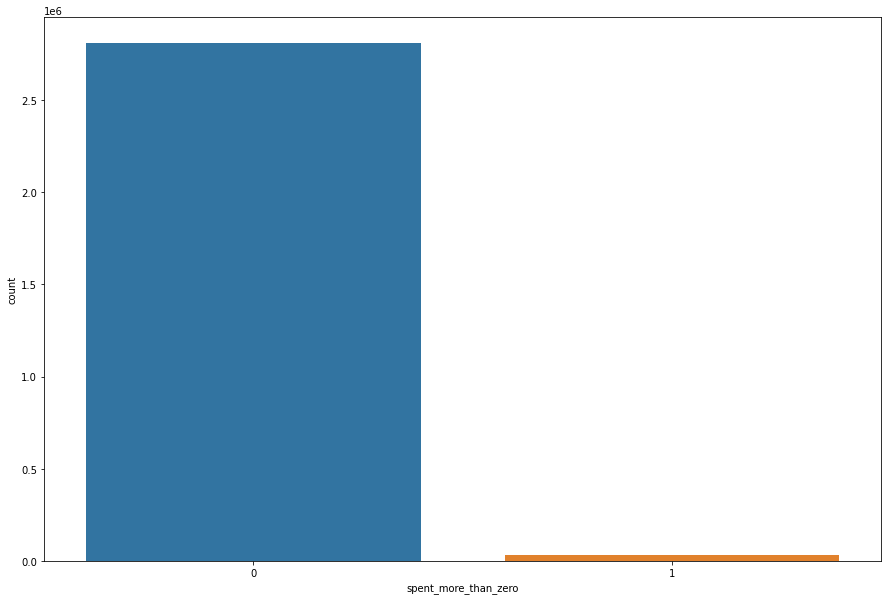

In [4]:
plt.figure(figsize=(15, 10))

sns.countplot(
    data=data, 
    x=target
    )


There seems to be massive class imbalance -- we'll have to take this into account when building the classifier

Since there's massive class imbalance, we'll do a stratified train/test split to make sure each dataset has around the same
proportion of the positive class.

In [5]:
train, test = train_test_split(
    data, 
    test_size=0.25, 
    random_state=RANDOM_SEED,
    stratify=data["spent_more_than_zero"]
)
train 

,spent_more_than_zero,game_stats_tutorial_complete_time,device_manufacturer_s,device_mapped_s,device_mem_i,device_gmem_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow
uid_s,,,,,,,,,,,,,,,,
178763,0,5.330000e+08,huawei,ldn-l21,2836.0,1024.0,8.0,720.0,adreno (tm) 505,android os 8.0.0 / api-26 (huaweildn-l21/158(c...,EN,PH,asia,28800,20.0,6
743582,0,2.842900e+10,huawei,huawei cun-l01,937.0,256.0,4.0,720.0,mali-t720,android os 5.1 / api-22 (huaweicun-l01/c150b139),EN,GR,europe,10800,4.0,1
1233133,0,NaN,apple,"iphone10,3",2823.0,1024.0,6.0,1125.0,apple a11 gpu,ios 12.2,EN,US,americas,-18000,20.0,2
1028247,0,NaN,apple,"ipad6,11",1977.0,512.0,2.0,1536.0,apple a9 gpu,ios 12.2,AR,KW,asia,10800,23.0,1
1953175,0,5.690000e+08,apple,"iphone10,4",1990.0,512.0,6.0,750.0,apple a11 gpu,ios 11.3,ES,MX,americas,-25200,21.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841585,1,7.730000e+08,apple,"iphone8,2",1987.0,512.0,2.0,1080.0,apple a9 gpu,ios 12.2,ZH-CN,CN,asia,28800,14.0,1
2251758,0,NaN,apple,ipad 2,502.0,128.0,2.0,768.0,powervr sgx 543,iphone os 9.3.5,RU,RU,europe,10800,8.0,1
489923,0,NaN,oppo,pacm00,5713.0,2048.0,8.0,1080.0,mali-g72 mp3,android os 8.1.0 / api-27 (o11019/1545477033),ZH-CN,CN,asia,28800,16.0,7


Now, let's do some visualizaation comparing the features to the target.

Outliers are removed to make the visualizations nicer, and we'll keep these outliers out of the training process.

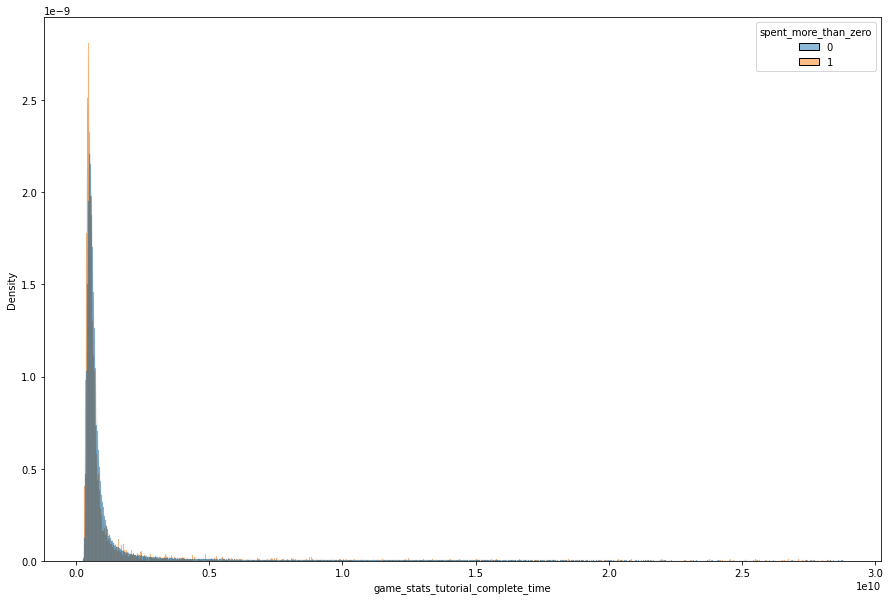

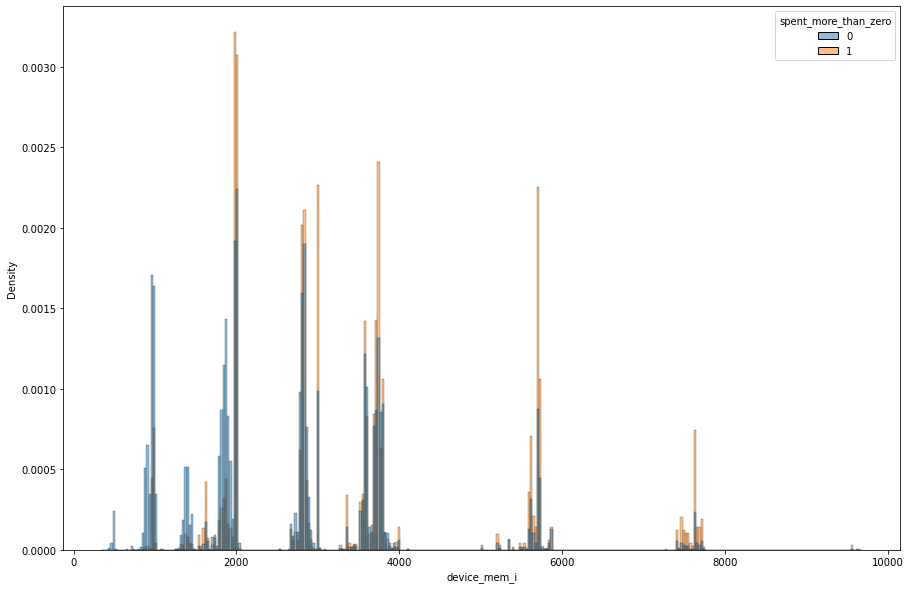

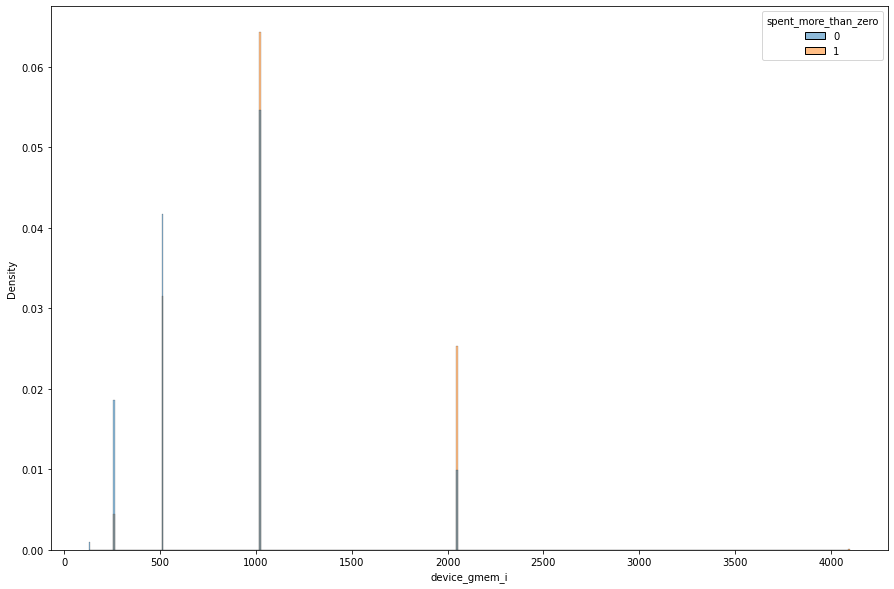

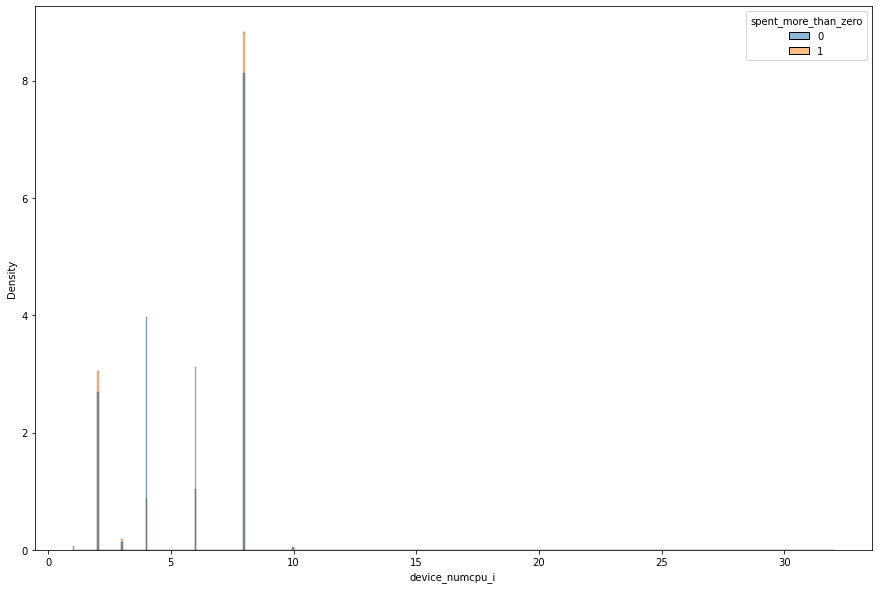

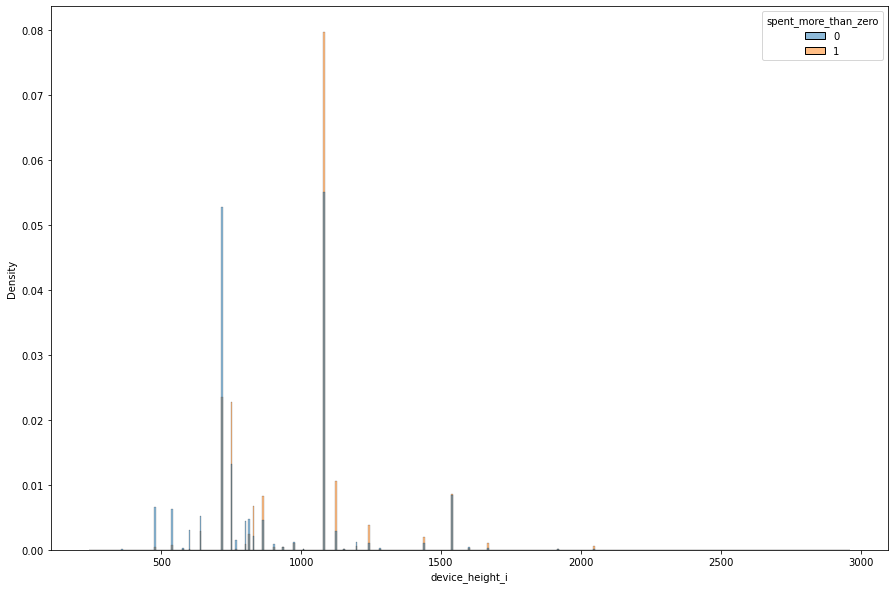

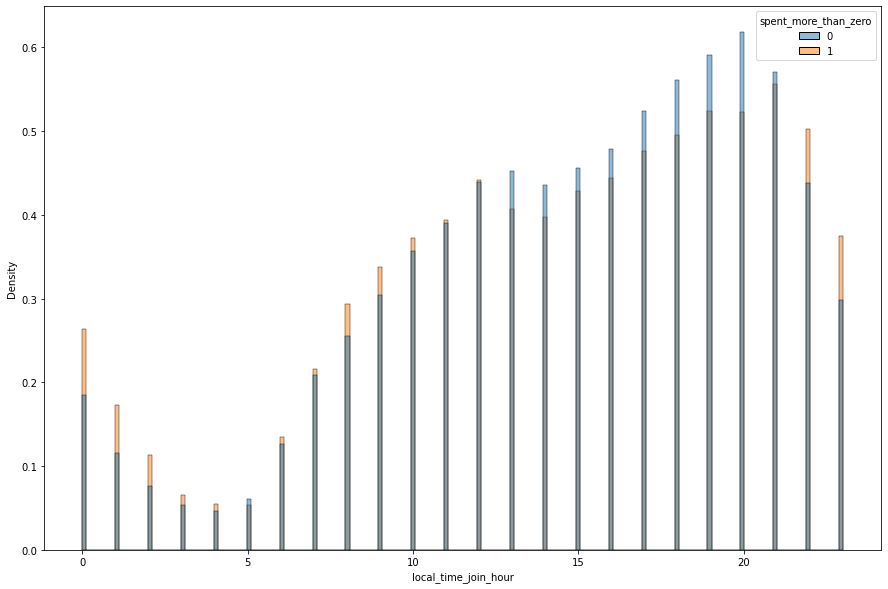

In [6]:
# Remove outliers
train = train.query("device_mem_i < 10000")
train = train.query("device_gmem_i < 5000")

numerical_features = [feature for feature in features if column_types[feature] == float]
for (i, feature) in enumerate(numerical_features):
    plt.figure(i, figsize=(15,10))
    sns.histplot(
        data=train,
        x=feature,
        hue=target,
        stat="density",
        common_norm=False
    )

The numerical features seem to decently capture differences between the two classes of the target.

Now let's examine the categorical features.

In [7]:
# Get a sense of the distribution of the levels of the categorical variables
categorical_features = [feature for feature in features if column_types[feature] == str]
for (i, feature) in enumerate(categorical_features):
    print("Describing categorical feature {}...".format(feature))
    print(train[feature].describe())
    print("Levels of categorical feature {}...".format(feature))
    print(train[feature].value_counts(dropna=False).head(10))
    print()

Describing categorical feature device_manufacturer_s...
count     2130082
unique       2711
top         apple
freq       496553
Name: device_manufacturer_s, dtype: object
Levels of categorical feature device_manufacturer_s...
apple       496553
samsung     429933
oppo        327696
huawei      267223
xiaomi      124713
vivo        117372
motorola     80660
lge          47962
lenovo       23006
meizu        22163
Name: device_manufacturer_s, dtype: int64

Describing categorical feature device_mapped_s...
count       2130082
unique        17464
top       iphone8,1
freq          41505
Name: device_mapped_s, dtype: object
Levels of categorical feature device_mapped_s...
iphone8,1     41505
iphone 6      38811
iphone 5s     30544
iphone9,3     29438
iphone11,8    25640
oppo a57      23204
iphone9,1     18614
iphone9,4     17744
oppo r9s      17401
iphone8,2     16884
Name: device_mapped_s, dtype: int64

Describing categorical feature device_gpu_s...
count             2130082
unique         

The categorical features seem to have many levels -- as a heuristic, we'll keep only the top five levels of each
categorical variable, and collapse the remaining into a level called "other". We'll then do some visualizations comparing
them to the target.
(For future work, I would collapse variables which are similar each other using domain knowledge.)

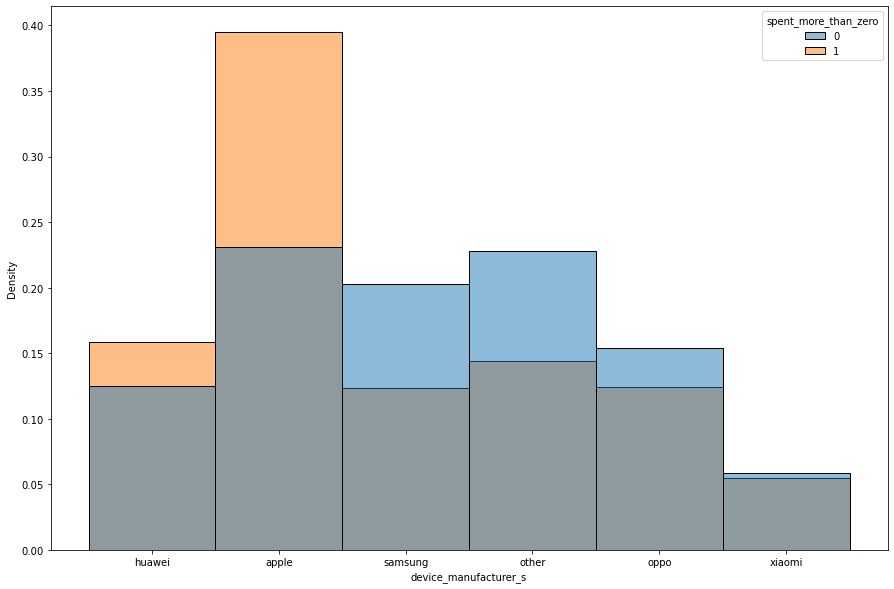

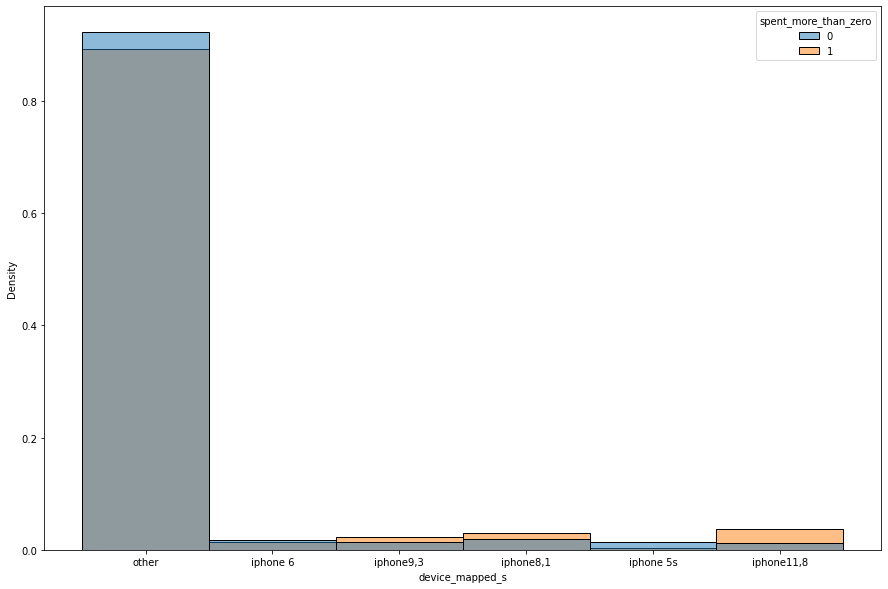

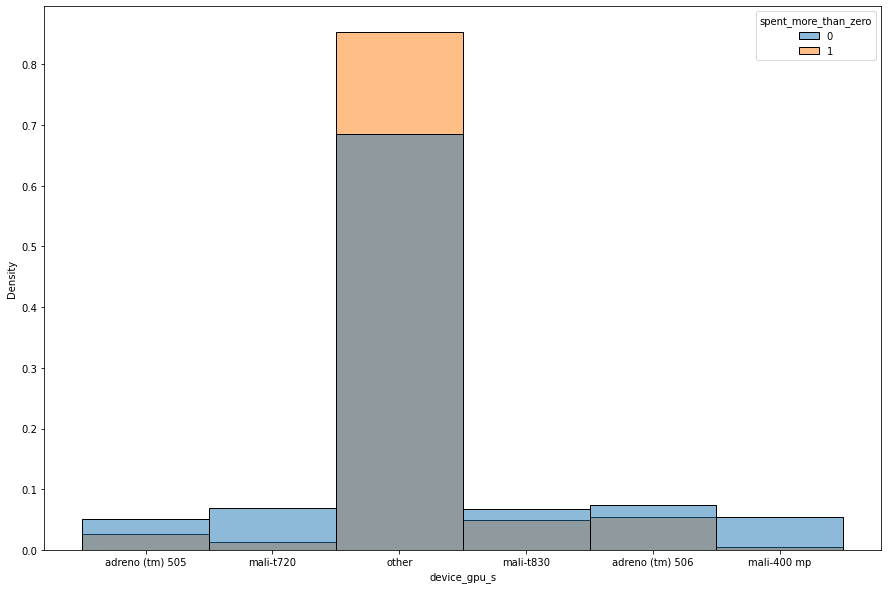

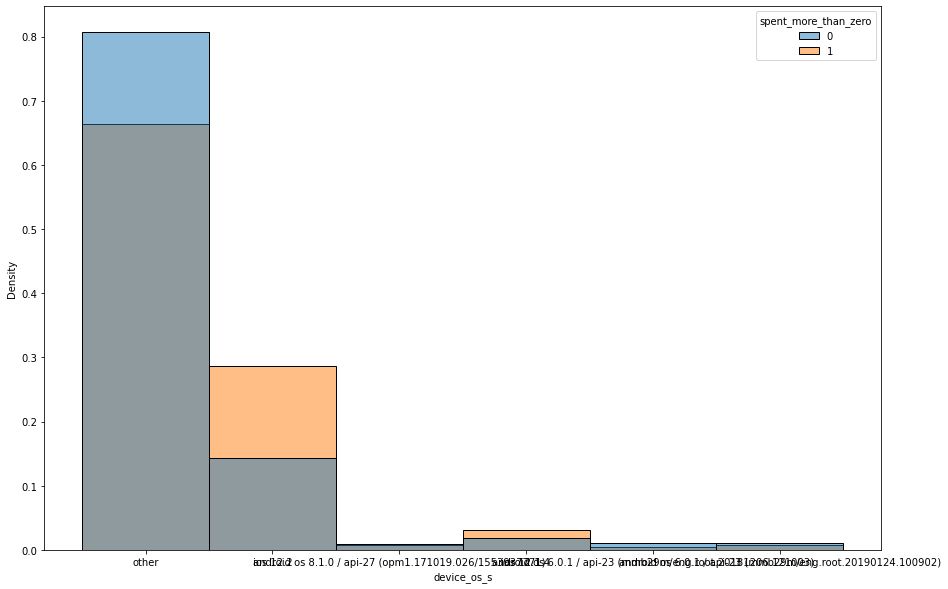

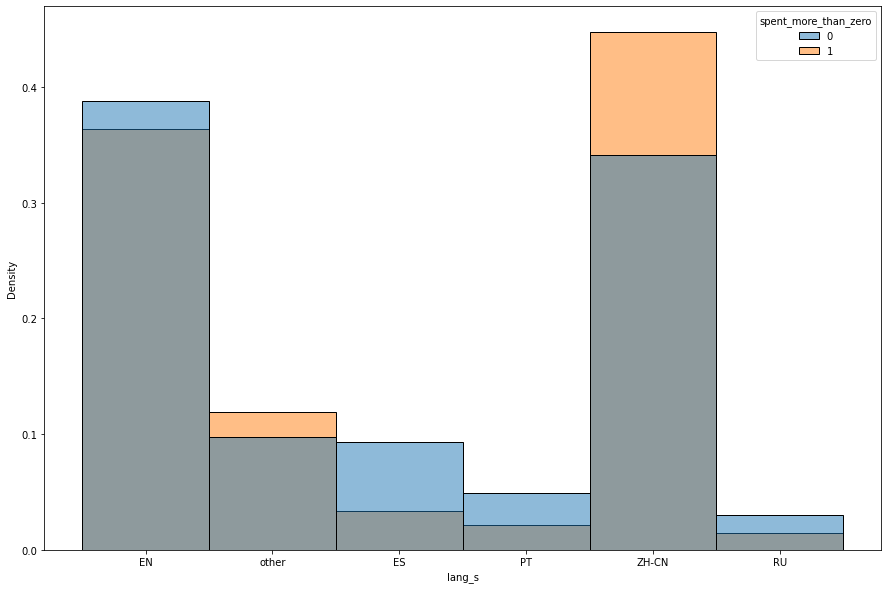

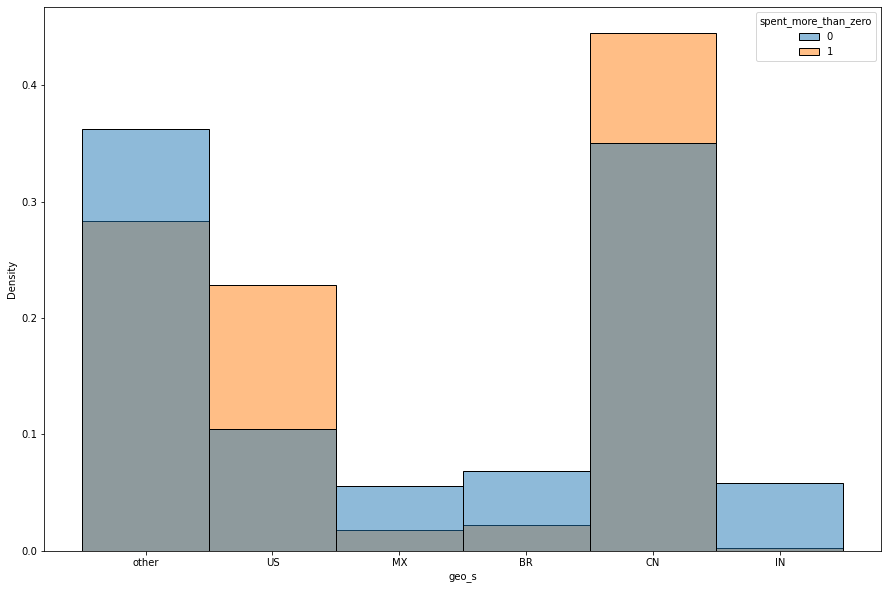

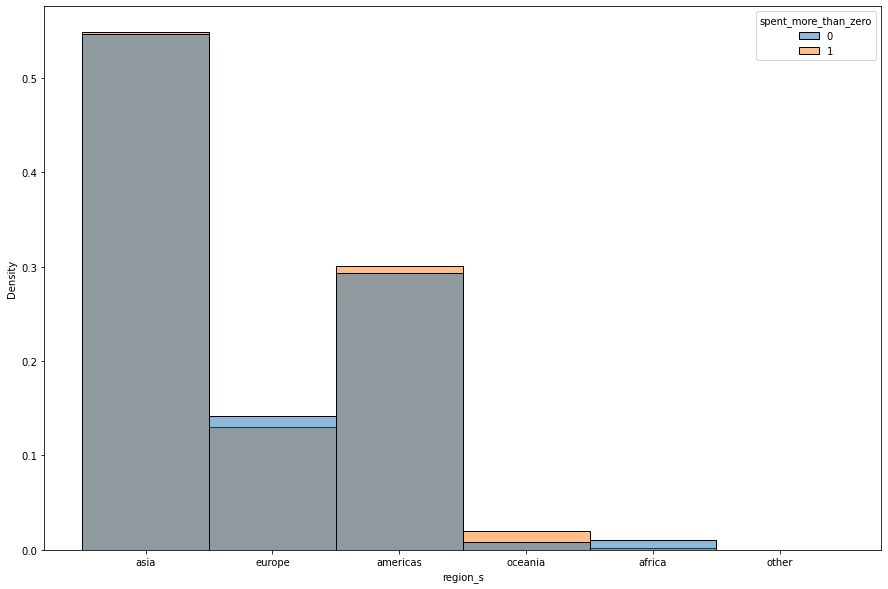

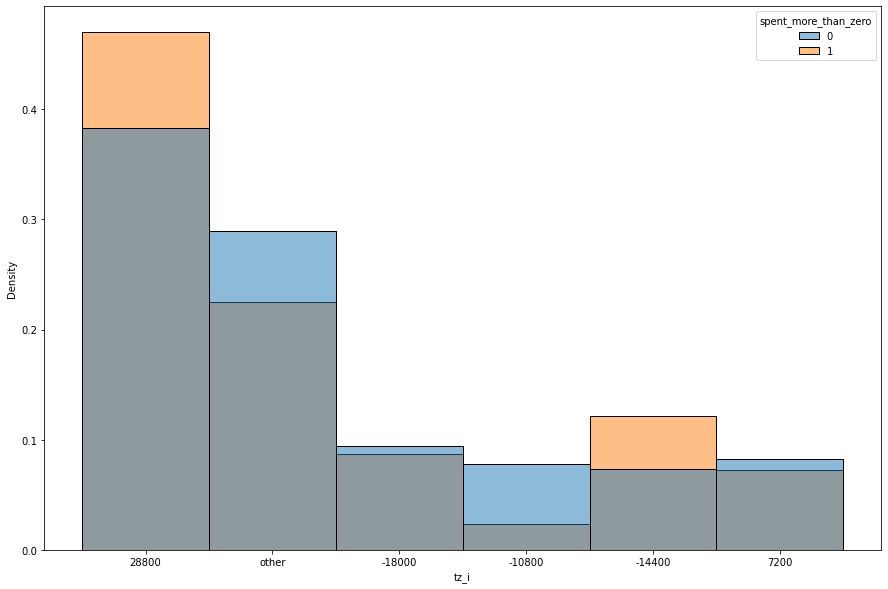

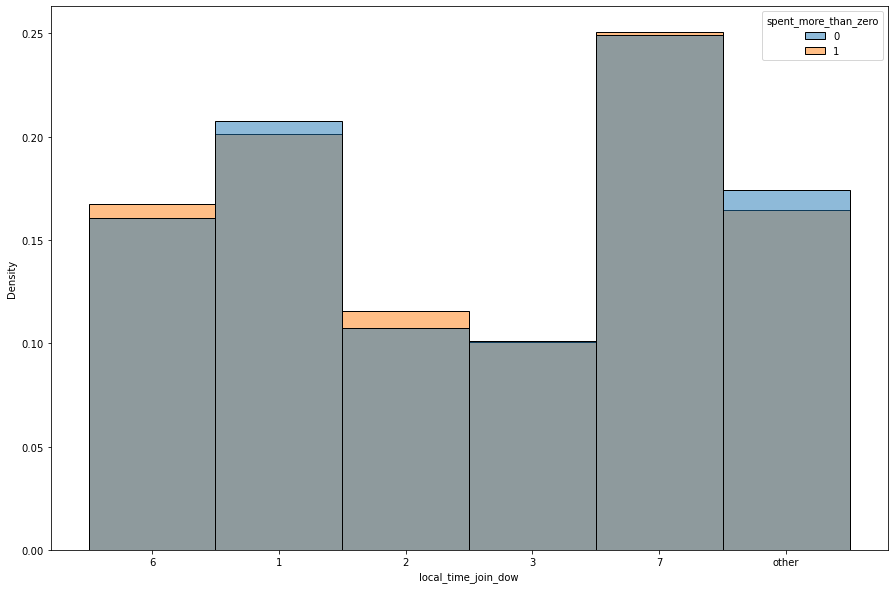

In [8]:
def keep_top_levels(data, categorical_features, num_levels=5):
    transformed_data = data.copy(deep=True)
    for feature in categorical_features:
        top_levels = transformed_data[feature].value_counts(dropna=False).head(num_levels).index.tolist()
        transformed_data.loc[:, feature] = transformed_data[feature].apply(
            lambda level: level if level in top_levels else "other"
        ) 
    return transformed_data

transformed_train = keep_top_levels(train, categorical_features, num_levels=5)

for feature in categorical_features:
    plt.figure(figsize=(15,10))
    sns.histplot(
        data=transformed_train,
        x=feature,
        hue=target,
        stat="density",
        common_norm=False
    )

The categorical variables seem to also capture differences between the two classes.

# Model Training

We use a gradient boosted trees model, using the default hyperparameters.

Since the dataset is so large, training takes four minutes at a time which is quite a long time. Therefore, we leave hyperparameter tuning for future work,
perhaps using a Bayesian optimization procedure.

In [9]:
# As a quick heuristic, for each categorical variable, keep the first few most frequent levels, and collapse the rest to
# be an "other" level.

# Create a custom sklearn data transformer so we can use sklearn's nifty pipeline object
class TopLevelsOneHotEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, categorical_features, num_levels=5):
        # Do a deepcopy to avoid accidentally modifying categorical_features
        self.categorical_features = list(categorical_features)
        self.num_levels = num_levels
        self.top_levels = {}
        self.is_fitted = False

    def fit(self, X, y=None):
        if self.is_fitted:
            raise Exception("Transformer has already been fit!")
        for feature in self.categorical_features:
            top_levels = X[feature].value_counts(dropna=False).head(self.num_levels).index.tolist()
            self.top_levels[feature] = set(top_levels + ["other"])
        return self
    
    def transform(self, X, y=None):
        transformed_X = X.copy(deep=True)
        for feature in self.categorical_features:
            if feature in transformed_X.columns:
                # Rename levels in dataframe
                top_levels = self.top_levels[feature]
                transformed_X.loc[:, feature] = transformed_X[feature].apply(
                    lambda level: level if level in top_levels else "other"
                )
                # Then one hot encode using pandas 
                dummies = pd.get_dummies(transformed_X[feature])
                for level in top_levels:
                    if level not in dummies.columns:
                        dummies.loc[:, level] = 0
                dummies.rename(inplace=True, columns={
                    level: "{}_{}".format(feature, level) for level in dummies.columns
                })
                transformed_X = pd.concat([transformed_X, dummies], axis=1)
                transformed_X.drop(columns=feature, inplace=True)
        return transformed_X

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

# Create a classifier that predicts whether the user will spend
model_file = "models/kabam.joblib"
train_new_model = True

if not os.path.exists(model_file) or train_new_model:
    print("Training new model...")
    num_spent_more_than_zero = train["spent_more_than_zero"].sum()
    num_spent_zero = len(train.index) - num_spent_more_than_zero
    classifier = xgb.XGBClassifier(
        random_state=RANDOM_SEED,
        # To address class imbalance, adjust weights of positive class
        scale_pos_weight=num_spent_zero/num_spent_more_than_zero,
        use_label_encoder=False,
        eval_metric="logloss"
        )

    pipeline = Pipeline([
        ("one_hot_encoder", TopLevelsOneHotEncoder(categorical_features, num_levels=5)),
        ("numerical_imputer", SimpleImputer()),    
        ("model", classifier)
    ])

    pipeline.fit(train[features], train[target])
    joblib.dump(pipeline, model_file)
else:
    print("Loading model...")
    pipeline = joblib.load(model_file)

test.loc[:, "spend_probability"] = pipeline.predict_proba(test[features])[:, 1]

Training new model...


# Model Evaluation

Now that the model has been trained, let's evaluate the model.

## Confusion matrix

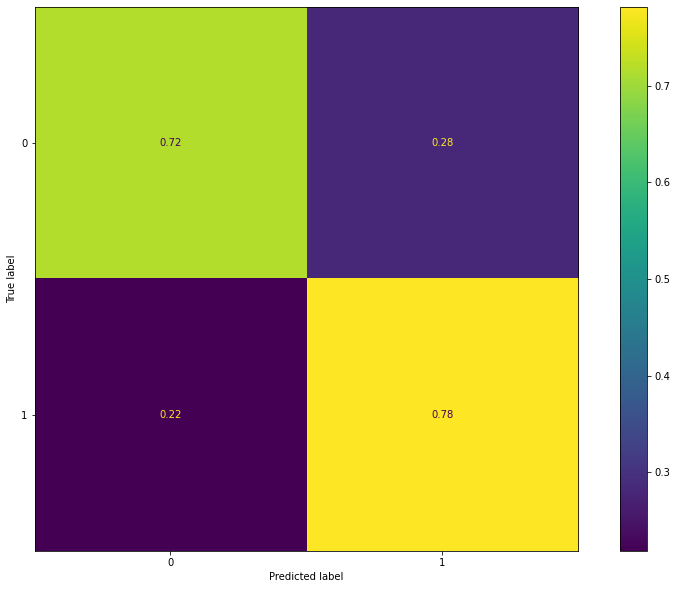

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline,
    test[features],
    test[target],
    ax=ax,
    normalize="true"
)

Above is the confusion matrix, where counts are normalized for each true label (numbers in each row sum to 1).

## What does the confusion matrix tell us?
- If the true label is 0 -- the user did not spend money in game after the tutorial -- the classifier is able to predict that accurately 72% of the time.
- If the true lavel is 1 -- the user did spend money after the tutorial -- the classifier is able to predict that accurately 78% of the time.

We have a good baseline model here, especially considering the massive class imbalance present in the dataset.
Therefore, insights given by the model could be useful.

# Business insights given by the model

Now let's determine what insights we can get from the model

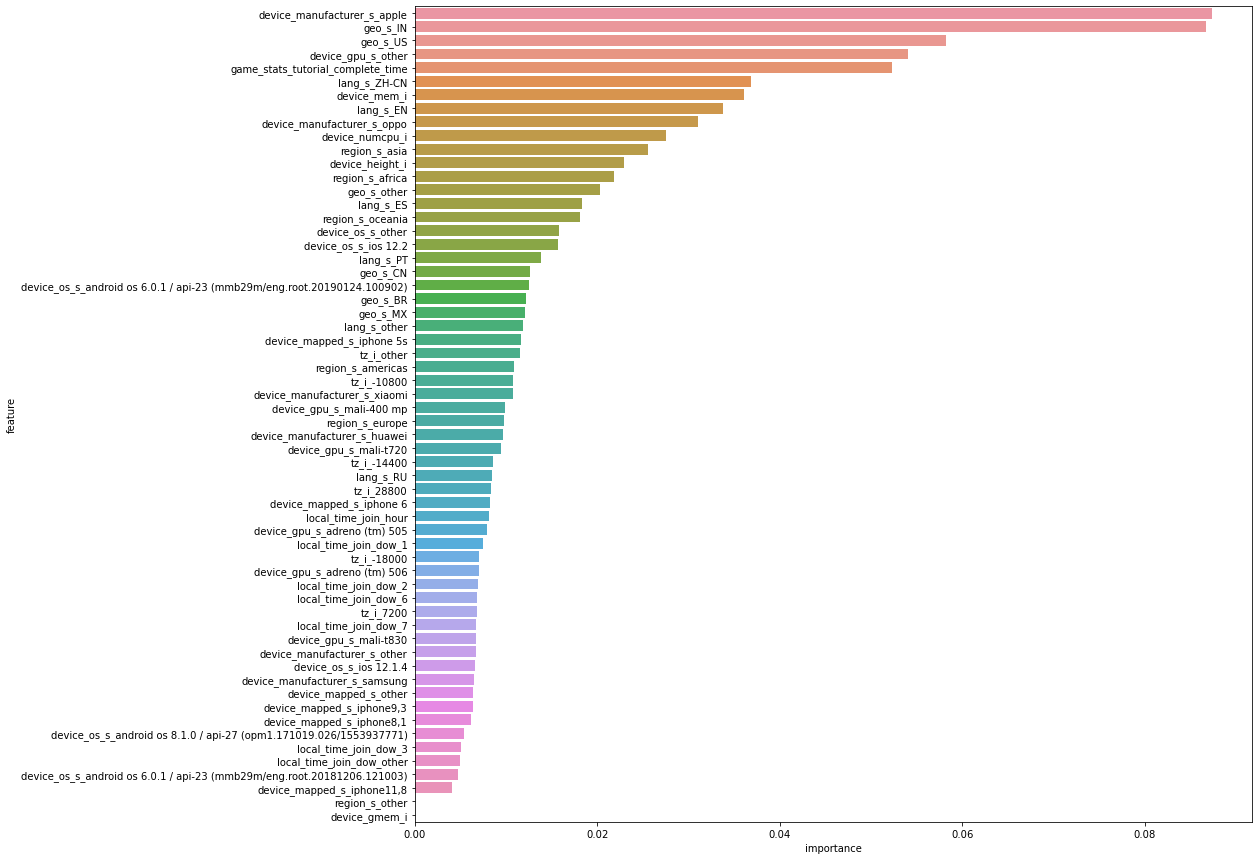

In [11]:
feature_names = pipeline["one_hot_encoder"].transform(test[features]).columns.tolist()
feature_importances = pipeline["model"].feature_importances_
feature_importances = pd.DataFrame(feature_importances, columns=["importance"])
feature_importances.loc[:, "feature"] = feature_names
feature_importances.sort_values(by="importance", inplace=True, ascending=False)

plt.figure(figsize=(15,15))
ax = sns.barplot(
   data=feature_importances,
   y="feature",
   x="importance" 
)

Above is feature importance chart as given by the model -- features on the top, with larger importance, are features
that the model thinks are important for prediction.

Some observations:
- Knowing whether the device manufacturer is Apple is the most important feature for the model.
- Knowing that the geographic location of the user is in India is quite important for the model.
- Knowing that the user's language is set to Chinese is useful for the model.
- Knowing how long it takes for the user to complete the tutorial is quite useful for the model.

# A case study

Here is a profile of a user which is quite **likely** to spend in game.

In [13]:
likely_to_spend = test.query("uid_s == '1770021'").iloc[0].copy(deep=True)
likely_to_spend["game_stats_tutorial_complete_time"] = likely_to_spend["game_stats_tutorial_complete_time"]/(1e6*60*60)
likely_to_spend.rename(
    index={"game_stats_tutorial_complete_time": "game_stats_tutorial_complete_time (hours)"}, 
    inplace=True
    )
likely_to_spend.drop(index="spent_more_than_zero", inplace=True)
print(likely_to_spend)

game_stats_tutorial_complete_time (hours)         1.890556
device_manufacturer_s                                apple
device_mapped_s                                 iphone11,6
device_mem_i                                        3735.0
device_gmem_i                                       1024.0
device_numcpu_i                                        6.0
device_height_i                                     1242.0
device_gpu_s                                 apple a12 gpu
device_os_s                                       ios 12.2
lang_s                                               ZH-CN
geo_s                                                   AU
region_s                                           oceania
tz_i                                                 36000
local_time_join_hour                                  20.0
local_time_join_dow                                      6
spend_probability                                 0.972676
Name: 1770021, dtype: object


Because the user is using an Apple device, is located in Australia, and has their language set to Chinese,
and spent a modest two hours in the tutorial, the user has a 98% probability of spending in game. Nice! We should raise prices
for this user.

On the other hand, here is the profile of a user that isn't likely to spend in game.

In [15]:
not_likely_to_spend = test.query("uid_s == '2775209'").iloc[0].copy(deep=True)
not_likely_to_spend["game_stats_tutorial_complete_time"] = not_likely_to_spend["game_stats_tutorial_complete_time"]/(1e6*60*60)
not_likely_to_spend.rename(
    index={"game_stats_tutorial_complete_time": "game_stats_tutorial_complete_time (hours)"}, 
    inplace=True
    )
not_likely_to_spend.drop(index="spent_more_than_zero", inplace=True)
print(not_likely_to_spend)

game_stats_tutorial_complete_time (hours)                                            7.726667
device_manufacturer_s                                                                 samsung
device_mapped_s                                                                      sm-j200g
device_mem_i                                                                            892.0
device_gmem_i                                                                           256.0
device_numcpu_i                                                                           4.0
device_height_i                                                                         540.0
device_gpu_s                                                                        mali-t720
device_os_s                                  android os 5.1.1 / api-22 (lmy47x/j200gddu2arl1)
lang_s                                                                                     EN
geo_s                                                       

Since the user is using non-Apple device -- a Samsung phone, is located in India, and spent almost eight hours in the tutorial (a very long time), this
user is unlikely to spend money in game, with a probability less than 1%! We should keep prices low for this user.

# Future work

Here are some ideas for future work:
- Perform some more exploratory data analysis, like correlation analysis between the features. This could allow us to remove more unnecessary features,
increasing the quality of the model.
- Collapse levels in the categorical features using domain knowledge, which could increase the performance of the model.
- Perform hyperparameter tuning of the XGBoost model to increase the performance of the model.
- Explore more methods to address massive class imbalance in classification tasks.